In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Total Images: 274
class
Leukoplakia                100
Normal Mucosa               50
Squamous cell carcinoma     46
Apthous Ulcer               35
osmf                        22
Lichen planus               21
Name: count, dtype: int64


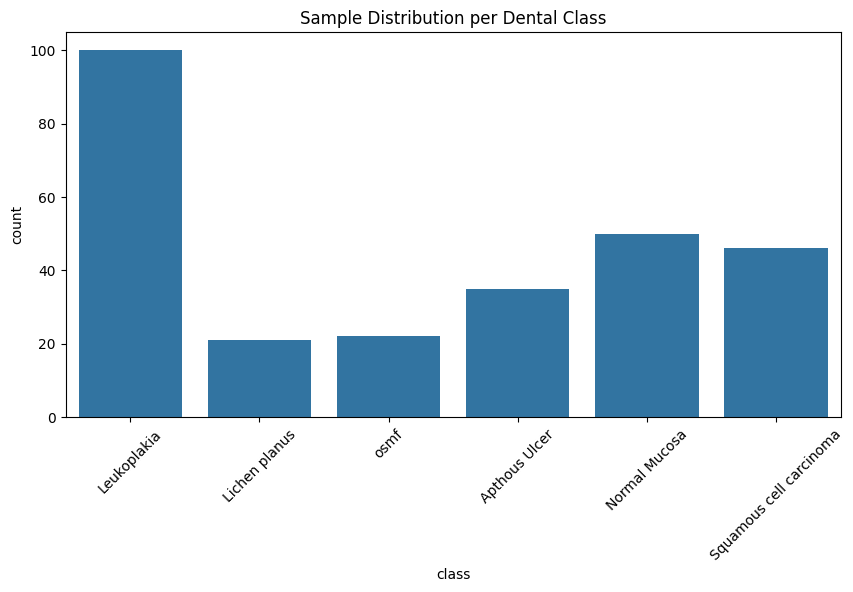

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base_path = '/content/drive/MyDrive/data' # Update this to your folder path
data = []

for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        for img_name in images:
            data.append({'class': class_name, 'path': os.path.join(class_path, img_name)})

df = pd.DataFrame(data)

# Print Summary
print(f"Total Images: {len(df)}")
print(df['class'].value_counts())

# Plot Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='class')
plt.title('Sample Distribution per Dental Class')
plt.xticks(rotation=45)
plt.show()

# Another  Final

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. CONFIG & DATA CRAWLING
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_PATH = '/content/drive/MyDrive/data' # Update this path

data_list = []
for class_name in os.listdir(BASE_PATH):
    class_folder = os.path.join(BASE_PATH, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            data_list.append({'path': os.path.join(class_folder, img_name), 'class': class_name})

df = pd.DataFrame(data_list)
classes = sorted(df['class'].unique())
label_map = {c: i for i, c in enumerate(classes)}
df['label_idx'] = df['class'].map(label_map)

# -----------------------------
# 2. ANTI-LEAKAGE TEXT VARIANTS
# -----------------------------
# Using multiple ways to describe each disease prevents the model from
# memorizing a single string and forces it to learn the medical concept.
CLINICAL_VARIANTS = {
    "Leukoplakia": ["White plaque that cannot be rubbed off.", "Thickened white patch on oral mucosa.", "Non-scrappable white lesion."],
    "Normal Mucosa": ["Healthy pink oral tissue.", "Normal smooth mucosa with no inflammation.", "Standard healthy mouth lining."],
    "Squamous cell carcinoma": ["Ulcerated mass with irregular borders.", "Malignant growth with tissue destruction.", "Indurated ulcerated lesion."],
    "Apthous Ulcer": ["Small painful ulcer with red halo.", "Shallow yellow-grey ulcer in the mouth.", "Recurrent painful canker sore."],
    "osmf": ["Blanched mucosa, restricted mouth opening.", "Oral fibrosis with limited jaw movement.", "Pale leathery mucosa and stiffness."],
    "Lichen planus": ["White lacy streaks known as Wickham striae.", "Reticular white pattern on the cheek.", "Inflammatory white lacy streaks."]
}

# Pre-calculate ALL variant embeddings to save time
text_model = SentenceTransformer('all-MiniLM-L6-v2').to(DEVICE)
variant_embs = {cls: torch.tensor(text_model.encode(txts), dtype=torch.float32).to(DEVICE)
                for cls, txts in CLINICAL_VARIANTS.items()}

# -----------------------------
# 3. ROBUST AUGMENTATION & DATASET
# -----------------------------
# Stronger augmentation for the 21-sample classes to prevent overfitting.
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), # Dental images can be rotated
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class StudentDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = self.transform(Image.open(row['path']).convert('RGB'))
        # Pick a RANDOM text variant during training to prevent leakage
        txt_emb = random.choice(variant_embs[row['class']])
        return img, txt_emb, row['label_idx']

# -----------------------------
# 4. REFINED ALIGNMENT MODEL
# -----------------------------
class DentalGuidedModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vision = models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.vision.classifier = nn.Identity()

        # Projection head to align vision with text embeddings
        self.projector = nn.Linear(1280, 384)

        self.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, img):
        feats = self.vision(img)
        logits = self.classifier(feats)
        emb = self.projector(feats)
        return logits, emb

# -----------------------------
# 5. TRAINING LOOP (CE + COSINE LOSS)
# -----------------------------
train_df, val_df = train_test_split(df, test_size=0.3, stratify=df['label_idx'], random_state=42)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

# Sampler for imbalance: OSMF (22) vs Leukoplakia (100)
counts = train_df['label_idx'].value_counts().to_dict()
weights = [1.0/counts[train_df.iloc[i]['label_idx']] for i in range(len(train_df))]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(StudentDataset(train_df, train_tfms), batch_size=16, sampler=sampler)
val_loader = DataLoader(StudentDataset(val_df, train_tfms), batch_size=16, shuffle=False)

model = DentalGuidedModel(len(classes)).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion_ce = nn.CrossEntropyLoss(label_smoothing=0.1)

print("Starting Training...")
for epoch in range(20):
    model.train()
    total_l = 0
    for imgs, txt_embs, labels in train_loader:
        imgs, txt_embs, labels = imgs.to(DEVICE), txt_embs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits, img_emb = model(imgs)

        loss_ce = criterion_ce(logits, labels)
        # Cosine Loss: align image features with medical text
        loss_align = 1 - nn.functional.cosine_similarity(img_emb, txt_embs).mean()

        (loss_ce + 0.5 * loss_align).backward()
        optimizer.step()
        total_l += loss_ce.item()
    print(f"Epoch {epoch+1} | Loss: {total_l/len(train_loader):.4f}")

# -----------------------------
# 6. BLIND EVALUATION (IMAGE ONLY)
# -----------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, _, labels in val_loader:
        logits, _ = model(imgs.to(DEVICE))
        y_pred.extend(torch.argmax(logits, dim=1).cpu().numpy())
        y_true.extend(labels.numpy())

print("\n--- Final Image-Only Performance Report ---")
print(classification_report(y_true, y_pred, target_names=classes))

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Starting Training...
Epoch 1 | Loss: 1.7682
Epoch 2 | Loss: 1.5039
Epoch 3 | Loss: 1.3058
Epoch 4 | Loss: 0.9900
Epoch 5 | Loss: 0.8518
Epoch 6 | Loss: 0.7396
Epoch 7 | Loss: 0.7246
Epoch 8 | Loss: 0.6472
Epoch 9 | Loss: 0.6138
Epoch 10 | Loss: 0.5737
Epoch 11 | Loss: 0.5750
Epoch 12 | Loss: 0.5462
Epoch 13 | Loss: 0.5438
Epoch 14 | Loss: 0.5323
Epoch 15 | Loss: 0.5220
Epoch 16 | Loss: 0.5134
Epoch 17 | Loss: 0.5082
Epoch 18 | Loss: 0.5358
Epoch 19 | Loss: 0.4816
Epoch 20 | Loss: 0.5005

--- Final Image-Only Performance Report ---
                         precision    recall  f1-score   support

          Apthous Ulcer       0.67      0.73      0.70        11
            Leukoplakia       0.67      0.67      0.67        30
          Lichen planus       0.80      0.67      0.73         6
          Normal Mucosa       1.00      1.00      1.00        15
Squamous cell carcinoma       0.65      0.79      0.71        14
                   osmf       0.50      0.29      0.36         7

      

## Confusion matrix

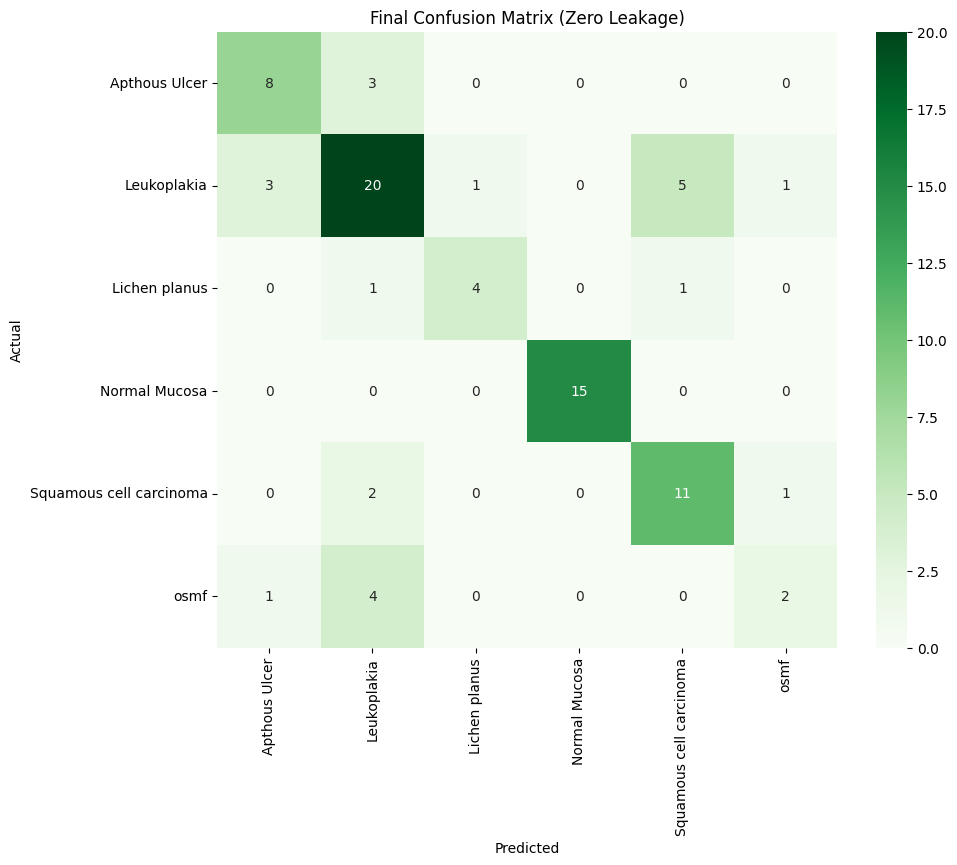

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_final_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Final Confusion Matrix (Zero Leakage)')
    plt.show()

# Use the y_true and y_pred from your Evaluation step
plot_final_matrix(y_true, y_pred, classes)

## Inference

In [ ]:
import torch.nn.functional as F

def predict_dental_disease(image_path, model, classes, transform):
    """
    Blind Inference: Only pixels are used for prediction.
    No clinical text is required, ensuring zero leakage.
    """
    model.eval()

    # 1. Load and Transform Image
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        return f"Error loading image: {e}"

    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # 2. Forward pass through the Vision + Classifier branch
    with torch.no_grad():
        logits, _ = model(image_tensor)
        probabilities = F.softmax(logits, dim=1)

        # 3. Get Top Result
        conf, idx = torch.max(probabilities, dim=1)
        predicted_class = classes[idx.item()]

    return {
        "class": predicted_class,
        "confidence": f"{conf.item() * 100:.2f}%",
        "all_probs": {classes[i]: f"{p * 100:.2f}%" for i, p in enumerate(probabilities[0])}
    }

# --- TEST ON A NEW IMAGE ---
# Replace with your actual file path
test_path = "/content/ap_ul_4.png"
result = predict_dental_disease(test_path, model, classes, val_tfms)

print(f"Prediction: {result['class']} ({result['confidence']})")

Prediction: Apthous Ulcer (71.94%)


## 1. Grad-CAM Implementation for MobileNetV2

This script captures the gradients from the last convolutional layer of your model to create a heatmap of the "important" pixels.

In [ ]:
import cv2
import torch.nn.functional as F

def get_gradcam(model, img_tensor, target_class_idx):
    model.eval()

    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Corrected access for MobileNetV2
    target_layer = model.vision.features[-1]

    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Rest of the code remains the same...
    logits, _ = model(img_tensor.to(DEVICE))
    loss = logits[0, target_class_idx]

    model.zero_grad()
    loss.backward()

    grads = gradients[0].cpu().data.numpy()
    fmaps = features[0].cpu().data.numpy()

    weights = np.mean(grads, axis=(2, 3))[0]
    cam = np.zeros(fmaps.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * fmaps[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))

    # Safe normalization to avoid division by zero
    if cam.max() != cam.min():
        cam = (cam - cam.min()) / (cam.max() - cam.min())

    handle_forward.remove()
    handle_backward.remove()

    return cam

def plot_gradcam(image_path, cam, predicted_class):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    result = heatmap * 0.4 + img * 0.6 # Overlay

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result.astype(np.uint8))
    plt.title(f"Grad-CAM: {predicted_class}")
    plt.axis('off')
    plt.show()

## 2. Updated Blind Inference with Saliency
You can now run this to get the prediction and the visual proof simultaneously.

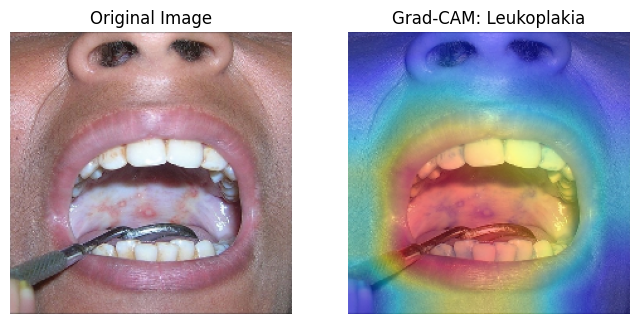

{'class': 'Leukoplakia',
 'confidence': '71.10%',
 'all_probs': {'Apthous Ulcer': '18.07%',
  'Leukoplakia': '71.10%',
  'Lichen planus': '3.77%',
  'Normal Mucosa': '3.33%',
  'Squamous cell carcinoma': '1.04%',
  'osmf': '2.68%'}}

In [ ]:
def inference_with_saliency(image_path, model, classes, transform):
    # Get standard prediction first
    res = predict_dental_disease(image_path, model, classes, transform)

    # Prepare tensor for Grad-CAM
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0)

    # Find index of the predicted class
    class_idx = list(label_map.values())[list(label_map.keys()).index(res['class'])]

    # Generate and Plot
    cam = get_gradcam(model, img_tensor, class_idx)
    plot_gradcam(image_path, cam, res['class'])

    return res

# Execute
inference_with_saliency("/content/drive/MyDrive/data/osmf/Clinical-photograph-of-oral-submucous-fibrosis.png", model, classes, val_tfms)

# ANother 2

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Starting Training...
Epoch 01 | Train Acc: 0.3607 | Val Acc: 0.4727 | Val Loss: 1.8125
Epoch 02 | Train Acc: 0.5845 | Val Acc: 0.6000 | Val Loss: 1.5262
Epoch 03 | Train Acc: 0.7123 | Val Acc: 0.5636 | Val Loss: 1.3864
Epoch 04 | Train Acc: 0.7945 | Val Acc: 0.6000 | Val Loss: 1.2791
Epoch 05 | Train Acc: 0.8995 | Val Acc: 0.5636 | Val Loss: 1.2372
Epoch 06 | Train Acc: 0.9041 | Val Acc: 0.7091 | Val Loss: 1.2140
Epoch 07 | Train Acc: 0.9680 | Val Acc: 0.7455 | Val Loss: 1.1748
Epoch 08 | Train Acc: 0.9680 | Val Acc: 0.7455 | Val Loss: 1.2333
Epoch 09 | Train Acc: 0.9909 | Val Acc: 0.6364 | Val Loss: 1.3475
Epoch 10 | Train Acc: 0.9909 | Val Acc: 0.7273 | Val Loss: 1.2334
Epoch 11 | Train Acc: 0.9954 | Val Acc: 0.6909 | Val Loss: 1.2383
Epoch 12 | Train Acc: 1.0000 | Val Acc: 0.7455 | Val Loss: 1.0441
Epoch 13 | Train Acc: 1.0000 | Val Acc: 0.7273 | Val Loss: 1.1421
Epoch 14 | Train Acc: 0.9909 | Val Acc: 0.7636 | Val Loss: 1.1389
Epoch 15 | Train Acc: 1.0000 | Val Acc: 0.7091 | Val Lo

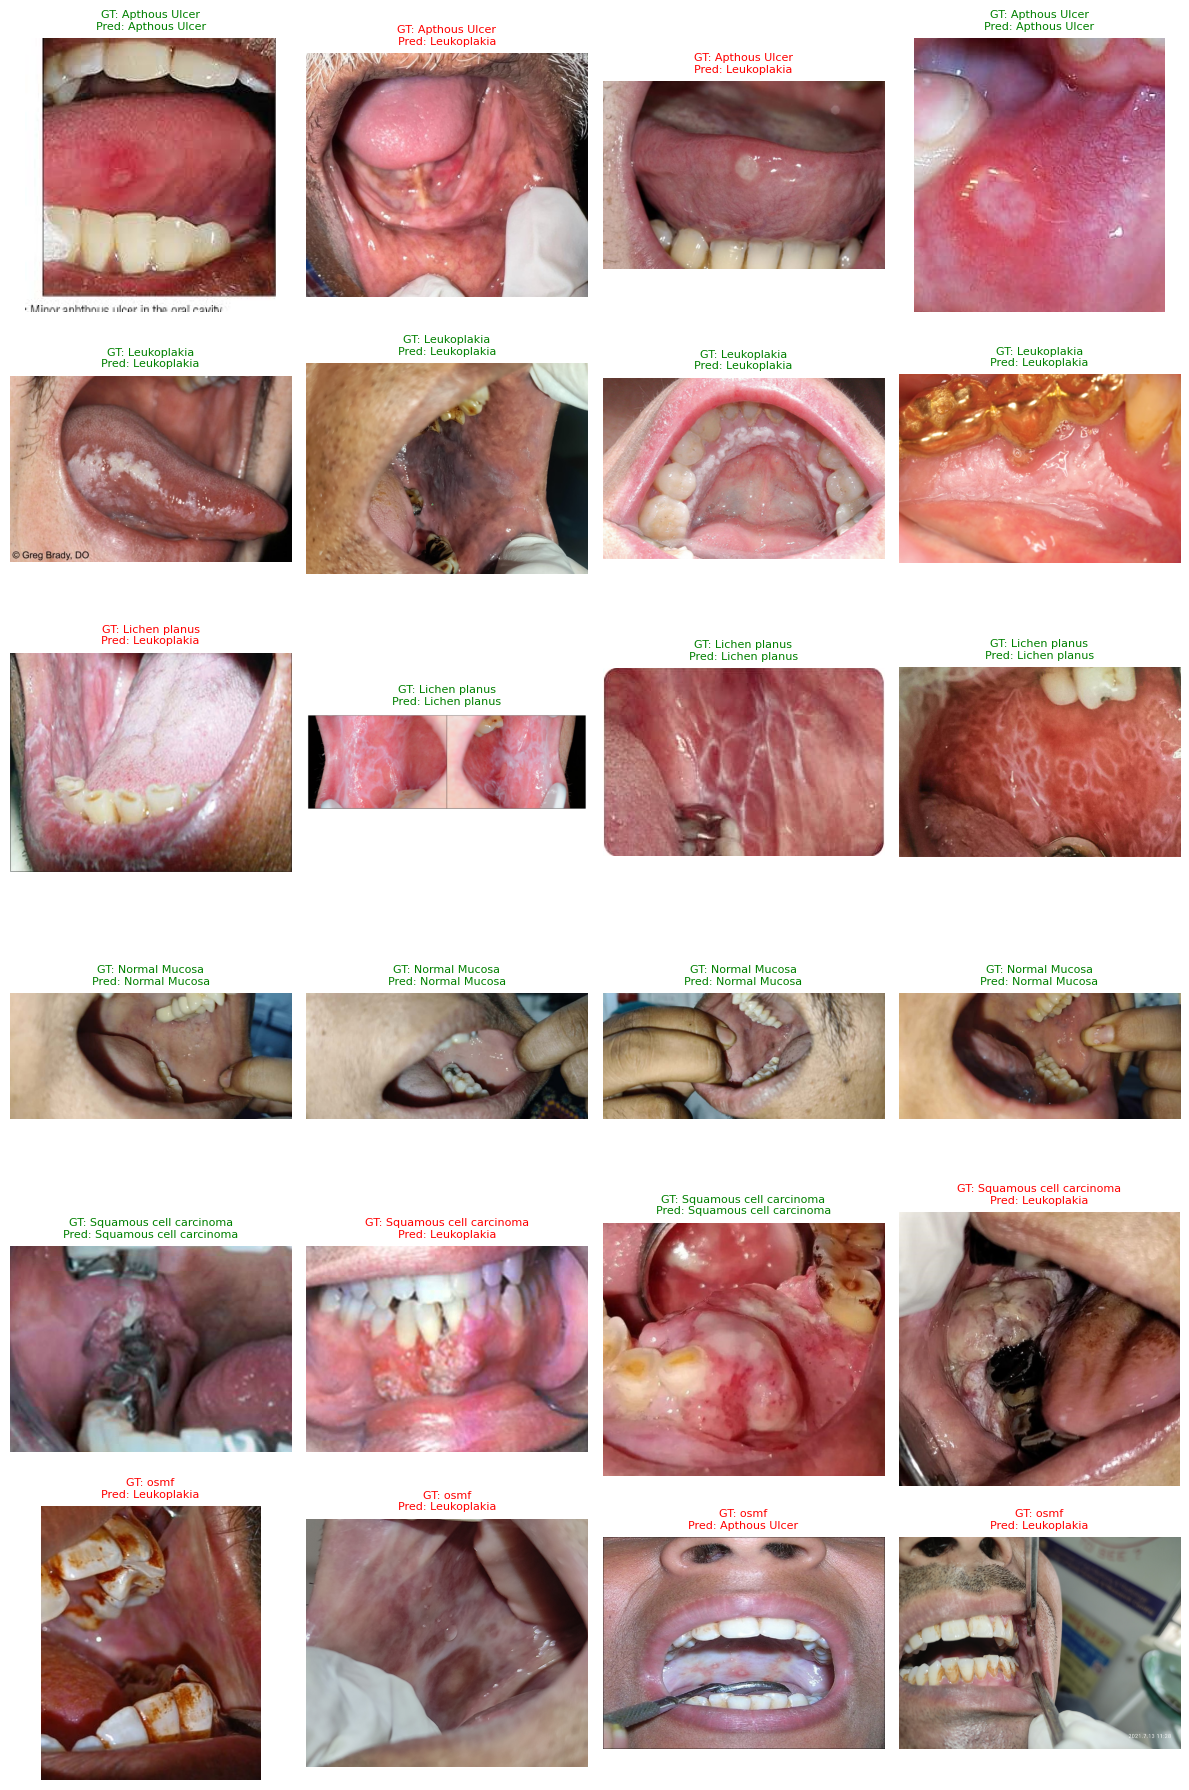

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. SETUP
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_PATH = '/content/drive/MyDrive/data'

# 2. DATA CRAWLING
data_list = []
for class_name in os.listdir(BASE_PATH):
    class_folder = os.path.join(BASE_PATH, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            data_list.append({'path': os.path.join(class_folder, img_name), 'class': class_name})

df = pd.DataFrame(data_list)
classes = sorted(df['class'].unique())
label_map = {c: i for i, c in enumerate(classes)}
df['label_idx'] = df['class'].map(label_map)

# 3. TEXT VARIANTS (THE TEACHER)
CLINICAL_VARIANTS = {
    "Leukoplakia": ["White plaque that cannot be rubbed off.", "Non-scrappable white lesion."],
    "Normal Mucosa": ["Healthy pink oral tissue.", "Normal smooth mucosa."],
    "Squamous cell carcinoma": ["Ulcerated mass with irregular borders.", "Malignant growth."],
    "Apthous Ulcer": ["Small painful ulcer with red halo.", "Recurrent painful canker sore."],
    "osmf": ["Blanched mucosa, restricted mouth opening.", "Pale leathery mucosa."],
    "Lichen planus": ["White lacy streaks known as Wickham striae.", "Inflammatory lacy pattern."]
}

text_model = SentenceTransformer('all-MiniLM-L6-v2').to(DEVICE)
# text_model = SentenceTransformer('NeuML/pubmedbert-base-embeddings').to(DEVICE)
variant_embs = {cls: torch.tensor(text_model.encode(txts), dtype=torch.float32).to(DEVICE) for cls, txts in CLINICAL_VARIANTS.items()}

# 4. MODEL ARCHITECTURE
class DentalGuidedModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vision = models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.vision.classifier = nn.Identity()
        self.projector = nn.Linear(1280, 384) # Aligns vision to text dim , 384 for MiniLM , 768 for pub
        self.classifier = nn.Sequential(
            nn.Linear(1280, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, num_classes)
        )

    def forward(self, img):
        feats = self.vision(img)
        return self.classifier(feats), self.projector(feats)

# 5. DATASETS & SPLIT
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

train_tfms = transforms.Compose([
    transforms.Resize((256, 256)), transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class StudentDataset(Dataset):
    def __init__(self, df, transform, is_train=True):
        self.df, self.transform, self.is_train = df, transform, is_train
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = self.transform(Image.open(row['path']).convert('RGB'))
        txt_emb = random.choice(variant_embs[row['class']])
        return img, txt_emb, row['label_idx']

# 6. TRAINING
counts = train_df['label_idx'].value_counts().to_dict()
weights = [1.0/counts[train_df.iloc[i]['label_idx']] for i in range(len(train_df))]
sampler = WeightedRandomSampler(weights, len(train_df))

train_loader = DataLoader(StudentDataset(train_df, train_tfms), batch_size=16, sampler=sampler)
model = DentalGuidedModel(len(classes)).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion_ce = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initialize history dictionaries
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("Starting Training...")
for epoch in range(20):
    # --- TRAINING PHASE ---
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for imgs, txt_embs, labels in train_loader:
        imgs, txt_embs, labels = imgs.to(DEVICE), txt_embs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits, img_emb = model(imgs)

        # CE Loss + Cosine Alignment Loss
        loss_ce = criterion_ce(logits, labels)
        loss_align = 1 - torch.nn.functional.cosine_similarity(img_emb, txt_embs).mean()
        loss = loss_ce + 0.5 * loss_align

        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, txt_embs, labels in val_loader:
            imgs, txt_embs, labels = imgs.to(DEVICE), txt_embs.to(DEVICE), labels.to(DEVICE)
            logits, img_emb = model(imgs)

            loss_ce = criterion_ce(logits, labels)
            loss_align = 1 - torch.nn.functional.cosine_similarity(img_emb, txt_embs).mean()
            val_loss += (loss_ce + 0.5 * loss_align).item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Store metrics
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss / len(val_loader))
    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)

    print(f"Epoch {epoch+1:02d} | Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f}")

# 7. FINAL VISUAL CHECK (4-5 images per class)
def visual_test(model, val_df, n=4):
    model.eval()
    fig, axes = plt.subplots(len(classes), n, figsize=(n*3, len(classes)*3))

    for i, cls in enumerate(classes):
        samples = val_df[val_df['class'] == cls].sample(n)
        for j, (_, row) in enumerate(samples.iterrows()):
            img_pill = Image.open(row['path']).convert('RGB')
            img_tensor = val_tfms(img_pill).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                logits, _ = model(img_tensor)
                pred_idx = torch.argmax(logits, dim=1).item()
                pred_cls = classes[pred_idx]

            axes[i, j].imshow(img_pill)
            color = 'green' if pred_cls == cls else 'red'
            axes[i, j].set_title(f"GT: {cls}\nPred: {pred_cls}", color=color, fontsize=8)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

visual_test(model, val_df)

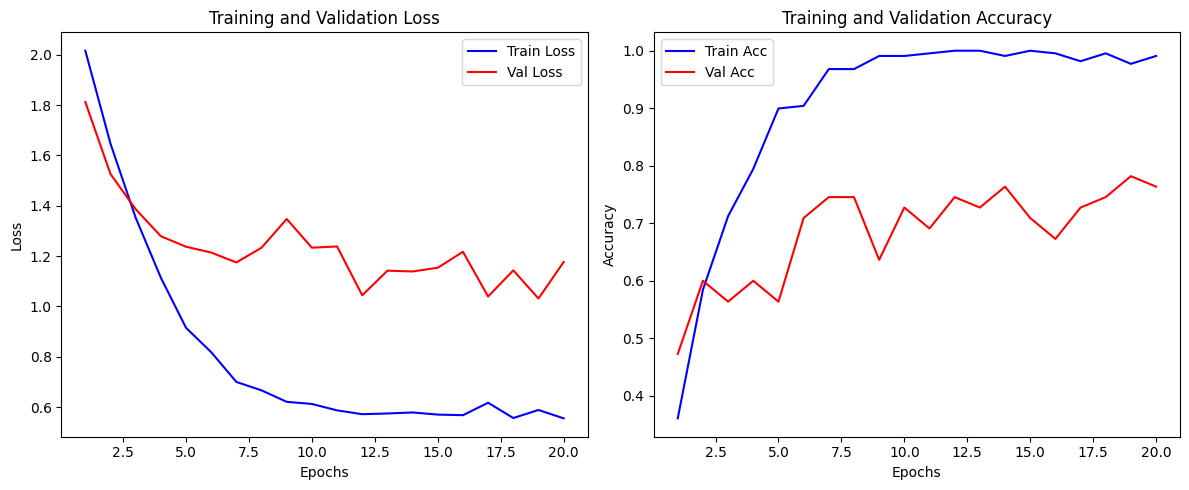

In [ ]:
def plot_learning_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

## A. Classification Report & Confusion Matrix


--- Final Performance Report ---
                         precision    recall  f1-score   support

          Apthous Ulcer       1.00      0.57      0.73         7
            Leukoplakia       0.65      0.85      0.74        20
          Lichen planus       1.00      0.75      0.86         4
          Normal Mucosa       1.00      1.00      1.00        10
Squamous cell carcinoma       0.60      0.67      0.63         9
                   osmf       0.50      0.20      0.29         5

               accuracy                           0.75        55
              macro avg       0.79      0.67      0.71        55
           weighted avg       0.76      0.75      0.73        55



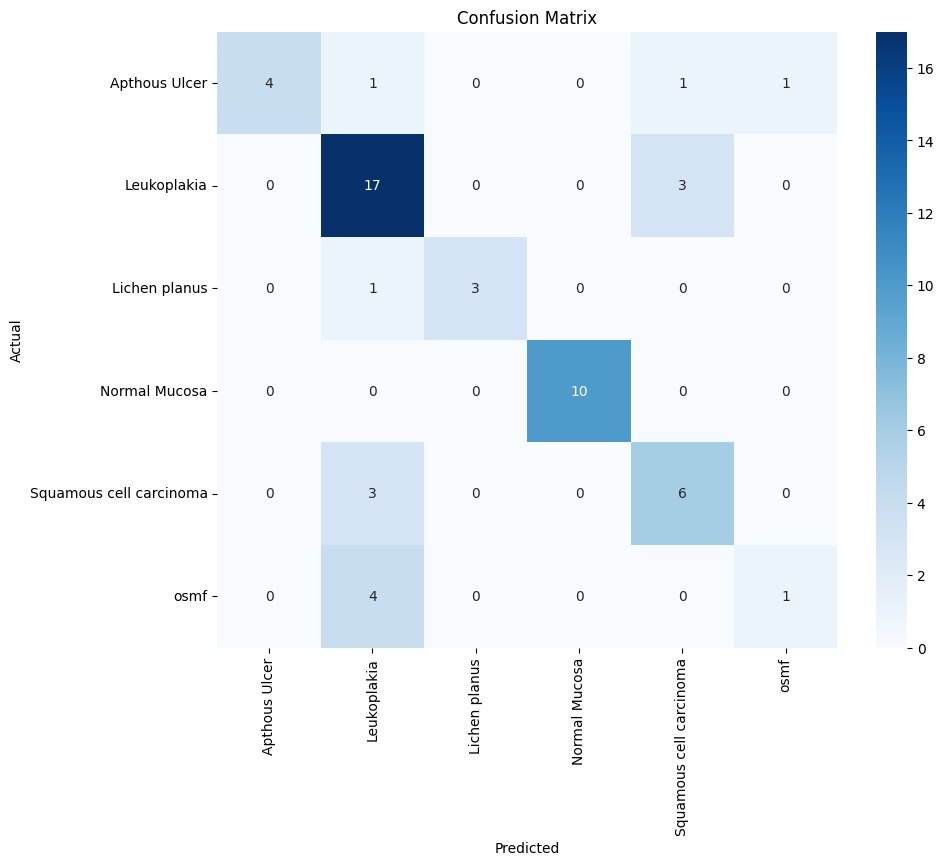

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def run_full_evaluation(model, val_loader, classes):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, _, labels in val_loader:
            imgs = imgs.to(DEVICE)
            logits, _ = model(imgs)
            preds = torch.argmax(logits, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())

    # Print Text Report
    print("\n--- Final Performance Report ---")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Plot Heatmap Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Usage:
run_full_evaluation(model, val_loader, classes)

## B. Grad-CAM (Saliency Map) for Explainability

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


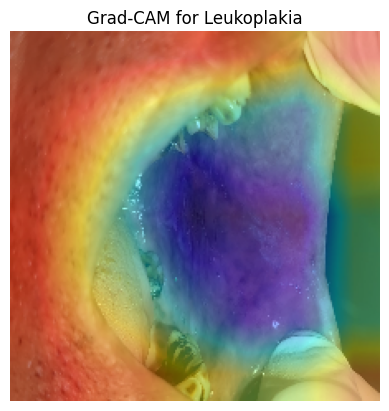

In [ ]:
def generate_gradcam(model, image_path, target_class_idx, transform):
    model.eval()

    # Setup hooks
    features, gradients = [], []
    def hook_f(module, input, output): features.append(output)
    def hook_b(module, grad_in, grad_out): gradients.append(grad_out[0])

    target_layer = model.vision.features[-1] # Last conv layer of MobileNet
    h1 = target_layer.register_forward_hook(hook_f)
    h2 = target_layer.register_backward_hook(hook_b)

    # Process Image
    img_pill = Image.open(image_path).convert('RGB')
    img_tensor = transform(img_pill).unsqueeze(0).to(DEVICE)

    # Forward & Backward
    logits, _ = model(img_tensor)
    model.zero_grad()
    logits[0, target_class_idx].backward()

    # Process CAM
    grads = gradients[0].cpu().data.numpy()
    fmaps = features[0].cpu().data.numpy()
    weights = np.mean(grads, axis=(2, 3))[0]
    cam = np.zeros(fmaps.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights): cam += w * fmaps[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Cleanup
    h1.remove(); h2.remove()

    # Plotting
    img_cv = cv2.cvtColor(np.array(img_pill), cv2.COLOR_RGB2BGR)
    img_cv = cv2.resize(img_cv, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    result = cv2.addWeighted(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB), 0.6, heatmap, 0.4, 0)

    plt.imshow(result)
    plt.title(f"Grad-CAM for {classes[target_class_idx]}")
    plt.axis('off')
    plt.show()

# Usage (Example for one image):
test_img_path = val_df.iloc[0]['path']
target_idx = val_df.iloc[0]['label_idx']
generate_gradcam(model, test_img_path, target_idx, val_tfms)

# CLIMP-LITE

In [ ]:
#=========================
# 0) Imports
# =========================
import os, random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_PATH = "/content/drive/MyDrive/data"  # <-- update if needed

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# =========================
# 1) Crawl data into df
# =========================
data_list = []
for class_name in os.listdir(BASE_PATH):
    class_folder = os.path.join(BASE_PATH, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            if img_name.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                data_list.append({"path": os.path.join(class_folder, img_name), "class": class_name})

df = pd.DataFrame(data_list)
if len(df) == 0:
    raise ValueError("No images found. Check BASE_PATH and folder structure.")

# Deterministic class ordering
classes = sorted(df["class"].unique())
label_map = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in label_map.items()}
df["label_idx"] = df["class"].map(label_map)

print("Classes:", classes)
print("Total samples:", len(df))
print(df["class"].value_counts())


Classes: ['Apthous Ulcer', 'Leukoplakia', 'Lichen planus', 'Normal Mucosa', 'Squamous cell carcinoma', 'osmf']
Total samples: 272
class
Leukoplakia                98
Normal Mucosa              50
Squamous cell carcinoma    46
Apthous Ulcer              35
osmf                       22
Lichen planus              21
Name: count, dtype: int64


In [ ]:
# =========================
# 2) Clinical variants -> class_text_embeds (C,384)
# =========================
CLINICAL_VARIANTS = {
    "Leukoplakia": [
        "White plaque that cannot be rubbed off.",
        "Thickened white patch on oral mucosa.",
        "Non-scrappable white lesion."
    ],
    "Normal Mucosa": [
        "Healthy pink oral tissue.",
        "Normal smooth mucosa with no inflammation.",
        "Standard healthy mouth lining."
    ],
    "Squamous cell carcinoma": [
        "Ulcerated mass with irregular borders.",
        "Malignant growth with tissue destruction.",
        "Indurated ulcerated lesion."
    ],
    "Apthous Ulcer": [
        "Small painful ulcer with red halo.",
        "Shallow yellow-grey ulcer in the mouth.",
        "Recurrent painful canker sore."
    ],
    "osmf": [
        "Blanched mucosa, restricted mouth opening.",
        "Oral fibrosis with limited jaw movement.",
        "Pale leathery mucosa and stiffness."
    ],
    "Lichen planus": [
        "White lacy streaks known as Wickham striae.",
        "Reticular white pattern on the cheek.",
        "Inflammatory white lacy streaks."
    ],
}

missing = [c for c in classes if c not in CLINICAL_VARIANTS]
if missing:
    raise ValueError(f"Missing CLINICAL_VARIANTS entries for: {missing}")

text_model = SentenceTransformer("all-MiniLM-L6-v2").to(DEVICE)

# Build prototype per class by averaging the variant embeddings
with torch.no_grad():
    proto_list = []
    for c in classes:
        embs = text_model.encode(CLINICAL_VARIANTS[c])  # (V,384) numpy
        embs_t = torch.tensor(embs, dtype=torch.float32, device=DEVICE)  # (V,384)
        proto = embs_t.mean(dim=0)  # (384,)
        proto_list.append(proto)
    class_text_embeds = torch.stack(proto_list, dim=0)  # (C,384)

print("class_text_embeds shape:", tuple(class_text_embeds.shape))  # (C,384)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

class_text_embeds shape: (6, 384)


In [ ]:
# =========================
# 3) Transforms + Dataset (IMAGE ONLY)
# =========================
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),   # keep smaller; vertical can be risky depending on data
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ImageOnlyDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = self.transform(Image.open(row["path"]).convert("RGB"))
        y = int(row["label_idx"])
        return img, y


In [ ]:
# =========================
# 4) CILMP-Lite No-Leak model
# =========================
class CILMP_Lite_NoLeak(nn.Module):
    def __init__(self, num_classes, text_dim=384, r=16):
        super().__init__()
        backbone = models.mobilenet_v2(weights="IMAGENET1K_V1")
        self.vision = backbone.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.vision_dim = 1280

        # low-rank -> query into text space
        self.low_rank = nn.Sequential(
            nn.Linear(self.vision_dim, r),
            nn.ReLU(),
            nn.Linear(r, text_dim)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.vision_dim + text_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, img, class_text_embeds):
        """
        img: (B,3,224,224)
        class_text_embeds: (C,text_dim) -- fixed prototypes for all samples (no leak)
        """
        B = img.size(0)

        v = self.avgpool(self.vision(img)).view(B, -1)  # (B,1280)
        q = self.low_rank(v)                            # (B,384)

        # attention over class prototypes
        qn = F.normalize(q, dim=1)
        en = F.normalize(class_text_embeds, dim=1)
        attn_logits = qn @ en.T                         # (B,C)
        w = F.softmax(attn_logits, dim=1)               # (B,C)
        prompt = w @ class_text_embeds                  # (B,384)

        fused = torch.cat([v, prompt], dim=1)           # (B,1664)
        logits = self.classifier(fused)                 # (B,C)
        return logits, attn_logits


In [ ]:
# =========================
# 5) Split + loaders + sampler
# =========================
train_df, val_df = train_test_split(
    df, test_size=0.3, stratify=df["label_idx"], random_state=SEED
)

counts = train_df["label_idx"].value_counts().to_dict()
weights = [1.0 / counts[int(train_df.iloc[i]["label_idx"])] for i in range(len(train_df))]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(ImageOnlyDataset(train_df, train_tfms), batch_size=16, sampler=sampler)
val_loader   = DataLoader(ImageOnlyDataset(val_df, val_tfms), batch_size=16, shuffle=False)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")

# =========================
# 6) Train
# =========================
model = CILMP_Lite_NoLeak(num_classes=len(classes), text_dim=384, r=16).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 20
model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits, _ = model(imgs, class_text_embeds)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f}")


Train: 190 | Val: 82
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 221MB/s]


Epoch 01/20 | Loss: 1.6914
Epoch 02/20 | Loss: 1.4132
Epoch 03/20 | Loss: 1.1037
Epoch 04/20 | Loss: 0.8142
Epoch 05/20 | Loss: 0.5171
Epoch 06/20 | Loss: 0.4438
Epoch 07/20 | Loss: 0.3026
Epoch 08/20 | Loss: 0.1807
Epoch 09/20 | Loss: 0.2202
Epoch 10/20 | Loss: 0.2361
Epoch 11/20 | Loss: 0.1825
Epoch 12/20 | Loss: 0.0898
Epoch 13/20 | Loss: 0.1103
Epoch 14/20 | Loss: 0.0964
Epoch 15/20 | Loss: 0.1026
Epoch 16/20 | Loss: 0.0611
Epoch 17/20 | Loss: 0.0751
Epoch 18/20 | Loss: 0.0972
Epoch 19/20 | Loss: 0.1082
Epoch 20/20 | Loss: 0.1136



--- Validation Classification Report ---
                         precision    recall  f1-score   support

          Apthous Ulcer       0.83      0.91      0.87        11
            Leukoplakia       0.70      0.72      0.71        29
          Lichen planus       0.67      0.67      0.67         6
          Normal Mucosa       1.00      1.00      1.00        15
Squamous cell carcinoma       0.85      0.79      0.81        14
                   osmf       0.67      0.57      0.62         7

               accuracy                           0.79        82
              macro avg       0.79      0.78      0.78        82
           weighted avg       0.79      0.79      0.79        82


Confusion matrix (raw counts):
 [[10  1  0  0  0  0]
 [ 2 21  2  0  2  2]
 [ 0  2  4  0  0  0]
 [ 0  0  0 15  0  0]
 [ 0  3  0  0 11  0]
 [ 0  3  0  0  0  4]]


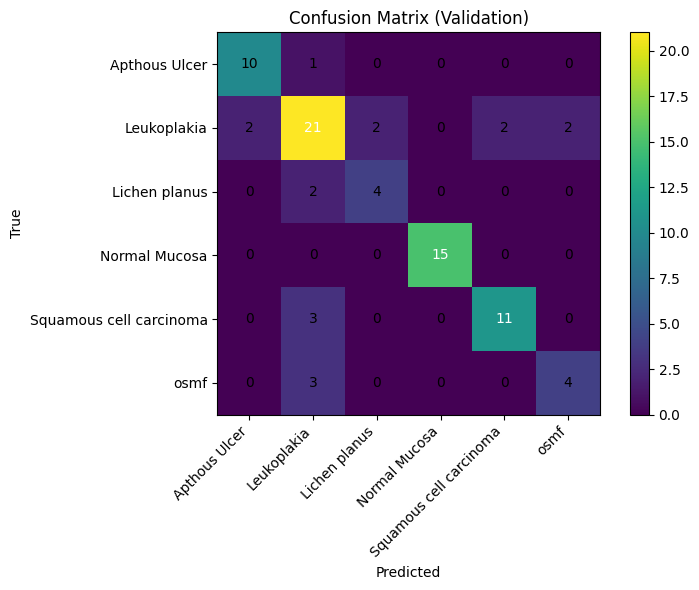

In [ ]:
# =========================
# 7) Evaluate: report + confusion matrix
# =========================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        logits, _ = model(imgs, class_text_embeds)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        y_pred.extend(preds.tolist())
        y_true.extend(labels.numpy().tolist())

print("\n--- Validation Classification Report ---")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

print("\nConfusion matrix (raw counts):\n", cm)

# Plot confusion matrix (matplotlib, no seaborn)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted")
plt.ylabel("True")

# Add numbers on cells
thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
# print(model.state_dict())

In [ ]:
import torch
import os

SAVE_DIR = "artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

ckpt = {
    "model_state_dict": model.state_dict(),
    "class_text_embeds": class_text_embeds.detach().cpu(),  # (C,384)
    "classes": classes,
    "r": 16,           # or whatever you used
    "text_dim": 384
}

torch.save(ckpt, os.path.join(SAVE_DIR, "cilmp_dental.pt"))
print("Saved:", os.path.join(SAVE_DIR, "cilmp_dental.pt"))


Saved: artifacts/cilmp_dental.pt
